2025-04-25 12:44:25,983 - __main__ - INFO - Starting fault detection pipeline...
2025-04-25 12:44:25,984 - __main__ - INFO - Loading data...
2025-04-25 12:44:25,984 - __main__ - INFO - Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\LG
Processing LG: 100%|██████████| 1/1 [00:00<00:00, 69.38it/s]
2025-04-25 12:44:26,016 - __main__ - INFO - Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\LL
Processing LL: 100%|██████████| 1/1 [00:00<00:00, 74.51it/s]
2025-04-25 12:44:26,031 - __main__ - INFO - Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\LLG
Processing LLG: 100%|██████████| 1/1 [00:00<00:00, 58.55it/s]
2025-04-25 12:44:26,052 - __main__ - INFO - Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\TLG
Processing TLG: 100%|██████████| 1/1 [00:00<00:00, 37.67it/s]
2025-04-25 12:44:26,084 - _

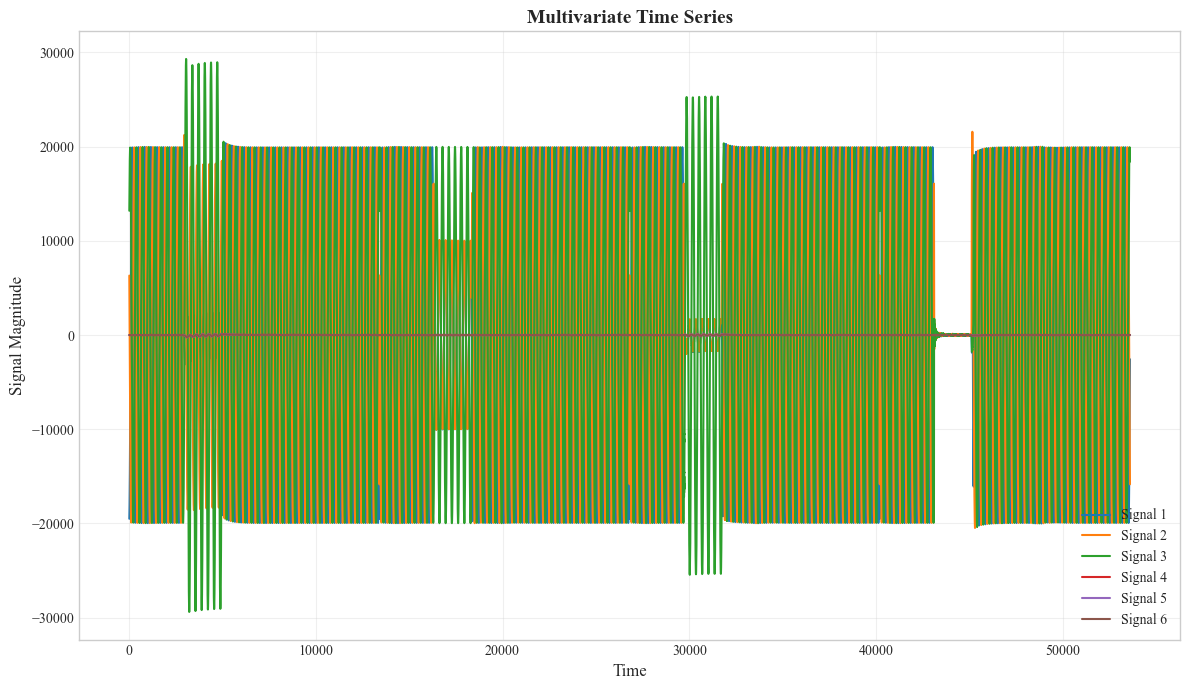

2025-04-25 12:44:27,373 - __main__ - INFO - Data shape: (53600, 6)
2025-04-25 12:44:27,373 - __main__ - INFO - Number of time points: 53600
2025-04-25 12:44:27,374 - __main__ - INFO - Column names: ['Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7']
2025-04-25 12:44:27,374 - __main__ - INFO - First few rows of data:
2025-04-25 12:44:27,376 - __main__ - INFO -           Var2         Var3         Var4      Var5      Var6      Var7
0 -19501.78456  6308.819964  13192.96460 -3.268245 -0.994472  4.262717
1 -19421.47512  5951.073775  13470.40135 -3.208124 -1.078143  4.286267
2 -19334.17336  5591.131380  13743.04198 -3.139545 -1.165160  4.304706
3 -19240.07873  5229.200849  14010.87788 -3.063683 -1.255075  4.318758
4 -19139.38255  4865.486949  14273.89560 -2.982180 -1.347192  4.329372
2025-04-25 12:44:27,380 - __main__ - INFO - 
Running HLLE + Mann-Whitney test...
2025-04-25 12:44:27,393 - __main__ - INFO - Calculating p-values with HLLE + Mann-Whitney U test...
100%|██████████| 2680/2680 [00:17<

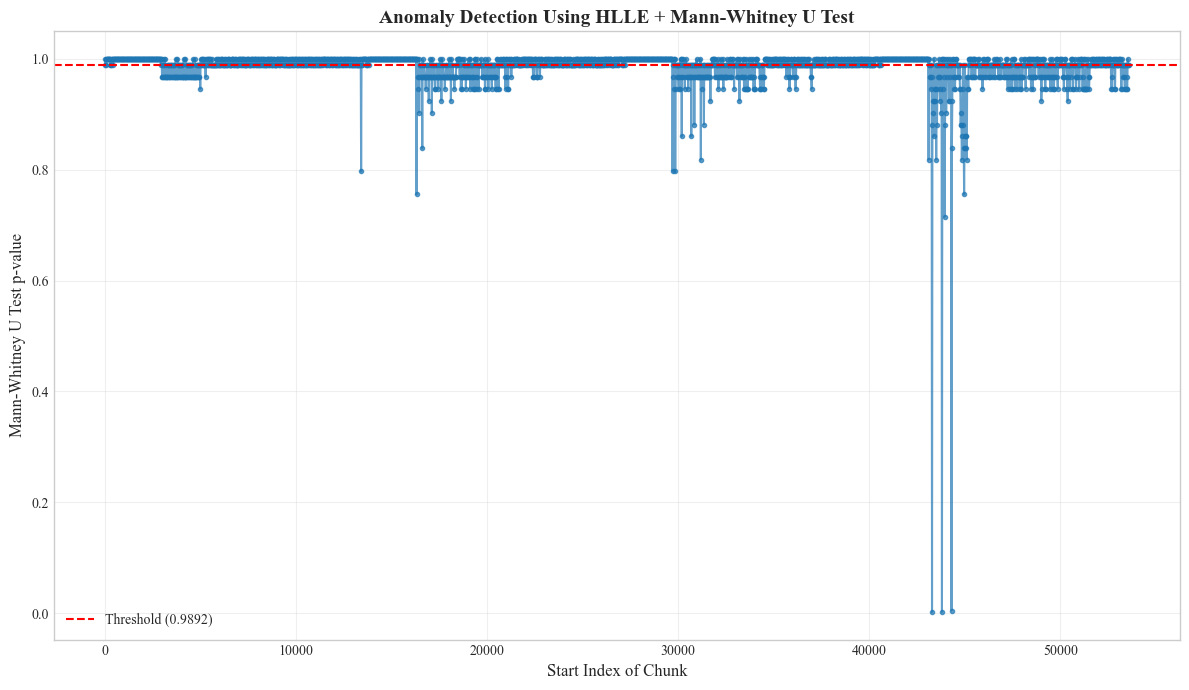

2025-04-25 12:44:44,627 - __main__ - INFO - 
Generating predictions from p-values...
2025-04-25 12:44:44,630 - __main__ - INFO - 
Plotting time series with highlighted fault regions...


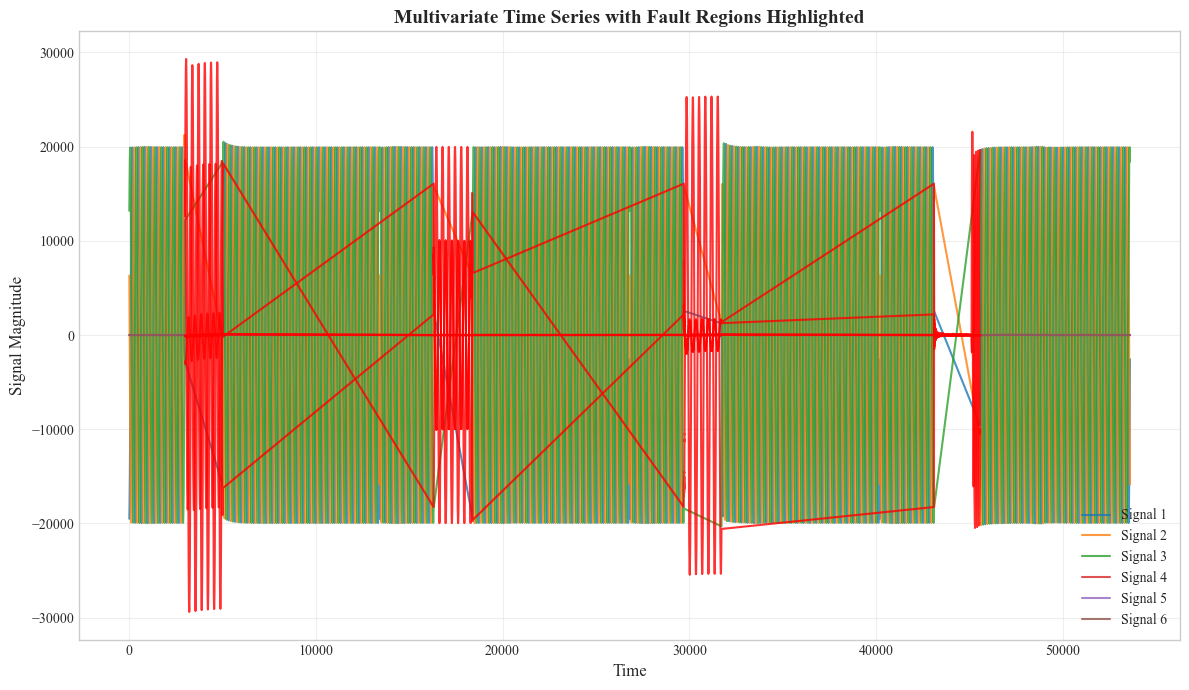

2025-04-25 12:44:46,060 - __main__ - INFO - 
Evaluating model performance...
2025-04-25 12:44:46,098 - __main__ - INFO - Model Evaluation Results:
2025-04-25 12:44:46,099 - __main__ - INFO - ========================
2025-04-25 12:44:46,100 - __main__ - INFO - Confusion Matrix:
[[42396     0]
 [ 2564  8640]]
2025-04-25 12:44:46,100 - __main__ - INFO - Accuracy     : 0.9522
2025-04-25 12:44:46,101 - __main__ - INFO - Precision    : 1.0000
2025-04-25 12:44:46,101 - __main__ - INFO - Recall       : 0.7712
2025-04-25 12:44:46,102 - __main__ - INFO - F1-score     : 0.8708
2025-04-25 12:44:46,103 - __main__ - INFO - Specificity  : 1.0000


<Figure size 800x600 with 0 Axes>

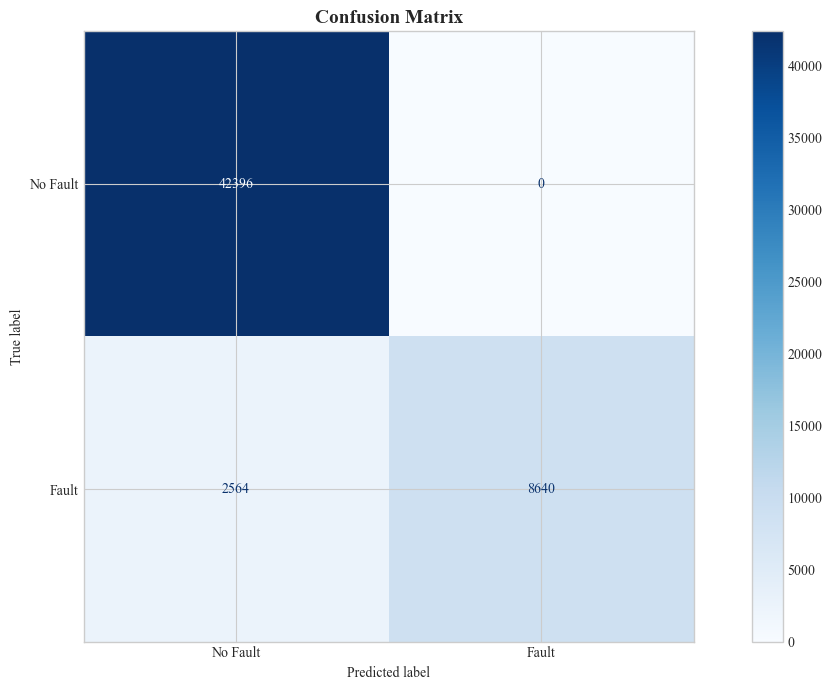

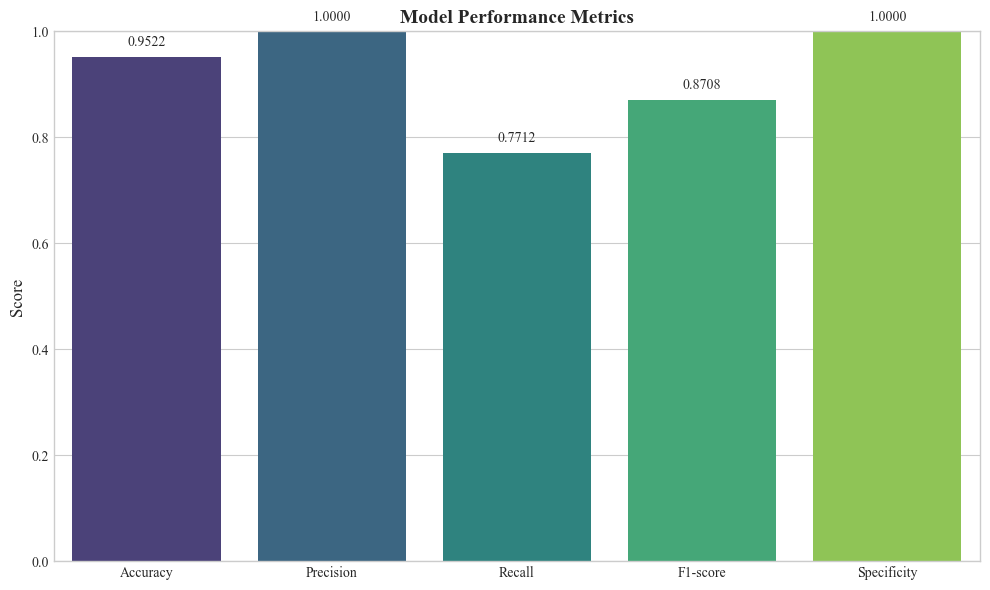

2025-04-25 12:44:46,487 - __main__ - INFO - Pipeline execution completed successfully.


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Fault Detection using Hessian Locally Linear Embedding (HLLE)

This script performs anomaly detection on multivariate time series data using
HLLE dimensionality reduction and statistical testing. It visualizes the results
and evaluates the model performance.

"""

import os
import glob
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Configure warnings and plot style
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

class FaultDetector:
    """
    A class for fault detection in multivariate time series data using
    Hessian Locally Linear Embedding (HLLE) and statistical testing.
    """
    
    def __init__(self, data_dir, chunk_size=20, neighbors=6, components=1, 
                 threshold=0.9892, segment_size=13400):
        """
        Initialize the FaultDetector with configuration parameters.
        
        Parameters:
        -----------
        data_dir : str
            Directory containing the data files.
        chunk_size : int, optional (default=20)
            Size of data chunks for processing.
        neighbors : int, optional (default=6)
            Number of neighbors for HLLE.
        components : int, optional (default=1)
            Number of components for HLLE.
        threshold : float, optional (default=0.9892)
            Threshold for anomaly detection.
        segment_size : int, optional (default=13400)
            Size of data segments.
        """
        self.data_dir = data_dir
        self.chunk_size = chunk_size
        self.neighbors = neighbors
        self.components = components
        self.threshold = threshold
        self.segment_size = segment_size
        
        # Initialize attributes to be set later
        self.data = None
        self.labels = None
        self.p_values = None
        self.step_indices = None
        self.pred_labels = None
        
    def load_and_merge_csv_data(self):
        """
        Load and merge CSV data from the specified directory.
        
        Returns:
        --------
        tuple
            (DataFrame, numpy.ndarray) containing the merged data and labels.
        """
        dfs = []
        labels = []
        
        try:
            for root, subfolders, _ in os.walk(self.data_dir):
                label_index = 0
                for folder in sorted(subfolders):
                    if folder != 'NF':
                        path = os.path.join(root, folder)
                        logger.info(f"Processing folder: {path}")
                        
                        csv_files = glob.glob(os.path.join(path, '*.csv'))
                        for file in tqdm(csv_files, desc=f"Processing {folder}"):
                            try:
                                df = pd.read_csv(file)
                                # Extract the meaningful part of the data
                                df = df.iloc[300:13700, :]
                                dfs.append(df)
                                labels.append(label_index)
                            except Exception as e:
                                logger.error(f"Error reading file {file}: {e}")
                        
                        label_index += 1
            
            if not dfs:
                raise ValueError("No data files were loaded. Check the directory path.")
                
            merged_df = pd.concat(dfs, ignore_index=True)
            self.data = merged_df
            self.labels = np.array(labels)
            
            logger.info(f"Loaded {len(dfs)} files with {merged_df.shape[0]} rows and {merged_df.shape[1]} columns")
            return merged_df, np.array(labels)
            
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise
    
    def examine_dataset(self, df=None):
        """
        Print detailed information about the dataset to help diagnose issues.
        
        Parameters:
        -----------
        df : pandas.DataFrame, optional
            DataFrame to examine. If None, uses self.data.
        """
        if df is None:
            df = self.data
            
        if df is None:
            logger.warning("No data available to examine.")
            return
            
        logger.info("DataFrame information:")
        logger.info(f"Shape: {df.shape}")
        logger.info(f"Columns: {df.columns.tolist()}")
        
        logger.info("\nFirst 5 rows:")
        logger.info(df.head())
        
        logger.info("\nData types:")
        logger.info(df.dtypes)
        
        logger.info("\nSummary statistics:")
        logger.info(df.describe())
        
        # Check for NaN values
        nan_count = df.isna().sum().sum()
        logger.info(f"\nTotal NaN values: {nan_count}")
        
        # Print information about each column
        logger.info("\nColumn details:")
        for col in df.columns:
            logger.info(f"Column '{col}': {len(df[col])} values, {df[col].nunique()} unique")
    
    def plot_timeseries(self, start_col=1, end_col=7):
        """
        Plot original multivariate time series data.
        
        Parameters:
        -----------
        start_col : int, optional (default=1)
            Starting column index for data.
        end_col : int, optional (default=7)
            Ending column index for data.
        """
        if self.data is None:
            logger.warning("No data available to plot.")
            return
            
        X = self.data.iloc[:, start_col:end_col].values
        time_axis = np.arange(len(X))
        
        plt.figure()
        for i in range(min(X.shape[1], 6)):
            plt.plot(time_axis, X[:, i], label=f'Signal {i+1}')
            
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Signal Magnitude", fontsize=12)
        plt.title("Multivariate Time Series", fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        # Print information about the data to help diagnose issues
        logger.info(f"Data shape: {X.shape}")
        logger.info(f"Number of time points: {len(time_axis)}")
        logger.info(f"Column names: {self.data.columns.tolist()[start_col:end_col]}")
        logger.info(f"First few rows of data:")
        logger.info(self.data.iloc[:5, start_col:end_col])
    
    def hlle_mann_whitney_test(self, start_col=1):
        """
        Calculate p-values from Mann-Whitney U test using HLLE.
        
        Parameters:
        -----------
        start_col : int, optional (default=1)
            Starting column index for data.
            
        Returns:
        --------
        tuple
            (p_values, step_indices) containing the test results.
        """
        if self.data is None:
            logger.warning("No data available for HLLE test.")
            return None, None
            
        X = self.data.iloc[:, start_col:].values
        baseline = X[:self.chunk_size, :]
        
        # Initialize HLLE
        hlle = LocallyLinearEmbedding(
            n_neighbors=self.neighbors,
            n_components=self.components,
            method='hessian',
            eigen_solver='dense',
            random_state=42
        )
        
        try:
            baseline_proj = hlle.fit_transform(baseline).flatten()
        except Exception as e:
            logger.error(f"Error during baseline HLLE projection: {e}")
            return None, None
            
        p_values = []
        step_indices = []
        
        # Process data in chunks
        logger.info("Calculating p-values with HLLE + Mann-Whitney U test...")
        for i in tqdm(range(0, len(X), self.chunk_size)):
            chunk = X[i:i + self.chunk_size, :]
            if len(chunk) < self.chunk_size:
                break
                
            try:
                chunk_proj = hlle.fit_transform(chunk).flatten()
                stat, p_value = stats.mannwhitneyu(baseline_proj, chunk_proj)
                p_values.append(p_value)
                step_indices.append(i)
            except Exception as e:
                logger.warning(f"Error processing chunk at index {i}: {e}")
                p_values.append(1.0)  # Conservative approach
                step_indices.append(i)
        
        self.p_values = np.array(p_values)
        self.step_indices = np.array(step_indices)
        
        # Plot p-values
        plt.figure()
        plt.plot(step_indices, p_values, marker='o', markersize=3, alpha=0.7)
        plt.xlabel("Start Index of Chunk", fontsize=12)
        plt.ylabel("Mann-Whitney U Test p-value", fontsize=12)
        plt.axhline(y=self.threshold, color='r', linestyle='--', 
                    label=f'Threshold ({self.threshold})')
        plt.title("Anomaly Detection Using HLLE + Mann-Whitney U Test", 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return np.array(p_values), step_indices
    
    def reshape_pvalues(self, group_size=670):
        """
        Reshape p-values into a matrix.
        
        Parameters:
        -----------
        group_size : int, optional (default=670)
            Size of each group.
            
        Returns:
        --------
        pandas.DataFrame
            Reshaped p-values.
        """
        if self.p_values is None:
            logger.warning("No p-values available to reshape.")
            return None
            
        reshaped = [self.p_values[i:i + group_size] 
                   for i in range(0, len(self.p_values), group_size)
                   if i + 1 <= len(self.p_values)]
                   
        return pd.DataFrame(np.array(reshaped).T)
    
    def generate_predictions(self, group_size=670):
        """
        Generate predictions from p-value matrix.
        
        Parameters:
        -----------
        group_size : int, optional (default=670)
            Size of each group.
            
        Returns:
        --------
        numpy.ndarray
            Predicted fault labels.
        """
        if self.p_values is None:
            logger.warning("No p-values available for prediction.")
            return None
        
        # Prepare values for prediction
        vals = []
        for i in range(0, len(self.p_values), group_size):
            segment = self.p_values[i:i + group_size]
            if len(segment) > 0:
                vals.append(segment)
        
        if not vals:
            logger.warning("Not enough p-values to generate predictions.")
            return None
            
        vals = np.array(vals).T  # Transpose to match original layout
        
        pred_segments = []
        size = vals.shape[0]  # Should be group_size (e.g., 670)
        
        for i in range(vals.shape[1]):  # Number of segments
            # Initialize with zeros (no fault)
            indi = np.zeros(self.segment_size)
            start = end = 0
            
            # Find start of fault region
            for j in range(size):
                if j >= 100 and vals[j, i] < self.threshold:
                    start = j
                    break
            
            # Find end of fault region
            if start != 0:
                for j in range(start + 1, size - 8):
                    if j < size and vals[j, i] > self.threshold:
                        flag = all(vals[j + k, i] > self.threshold 
                                  for k in range(min(8, size - j)))
                        if flag:
                            end = j
                            break
            
            # Mark fault region
            for j in range(start, end + 1):
                if j * self.chunk_size < self.segment_size:
                    end_idx = min((j + 1) * self.chunk_size, self.segment_size)
                    indi[j * self.chunk_size : end_idx] = 1
                    
            pred_segments.append(indi)
        
        self.pred_labels = np.concatenate(pred_segments).astype(int)
        return self.pred_labels
    
    def plot_timeseries_with_highlights(self, start_col=1, end_col=7):
        """
        Plot time series with fault regions highlighted in red.
        
        Parameters:
        -----------
        start_col : int, optional (default=1)
            Starting column index for data.
        end_col : int, optional (default=7)
            Ending column index for data.
        """
        if self.data is None or self.pred_labels is None:
            logger.warning("Data or predictions missing for highlight plot.")
            return
            
        X = self.data.iloc[:len(self.pred_labels), start_col:end_col].values
        time_axis = np.arange(len(X))
        
        plt.figure()
        
        # Get fault regions from predictions
        fault_mask = self.pred_labels == 1
        normal_mask = self.pred_labels == 0
        
        # Plot normal regions in distinct colors
        for i in range(min(X.shape[1], 6)):
            plt.plot(time_axis[normal_mask], X[normal_mask, i], 
                    label=f'Signal {i+1}',
                    color=f'C{i}', alpha=0.8)
        
        # Plot fault regions in red
        for i in range(min(X.shape[1], 6)):
            plt.plot(time_axis[fault_mask], X[fault_mask, i], 
                    color='red', linewidth=1.5, alpha=0.8)
        
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Signal Magnitude", fontsize=12)
        plt.title("Multivariate Time Series with Fault Regions Highlighted", 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self):
        """
        Evaluate the model performance and display the confusion matrix and metrics.
        """
        if self.data is None or self.pred_labels is None:
            logger.warning("Data or predictions missing for evaluation.")
            return
            
        if 'LABEL' not in self.data.columns:
            logger.warning("No 'LABEL' column found for confusion matrix.")
            return
            
        ground_truth = self.data['LABEL'][:len(self.pred_labels)].values
        predictions = self.pred_labels
        
        conf_matrix = confusion_matrix(ground_truth, predictions)
        accuracy = accuracy_score(ground_truth, predictions)
        precision = precision_score(ground_truth, predictions)
        recall = recall_score(ground_truth, predictions)
        f1 = f1_score(ground_truth, predictions)
        
        # Calculate specificity
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) \
                      if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
        
        # Print evaluation metrics
        logger.info("Model Evaluation Results:")
        logger.info("========================")
        logger.info(f"Confusion Matrix:\n{conf_matrix}")
        logger.info(f"Accuracy     : {accuracy:.4f}")
        logger.info(f"Precision    : {precision:.4f}")
        logger.info(f"Recall       : {recall:.4f}")
        logger.info(f"F1-score     : {f1:.4f}")
        logger.info(f"Specificity  : {specificity:.4f}")
        
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['No Fault', 'Fault'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Plot additional evaluation metrics
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity']
        values = [accuracy, precision, recall, f1, specificity]
        
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=metrics, y=values, palette='viridis')
        plt.ylim(0, 1.0)
        plt.ylabel('Score', fontsize=12)
        plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
        
        # Add value labels
        for i, v in enumerate(values):
            ax.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)
            
        plt.tight_layout()
        plt.show()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'specificity': specificity,
            'confusion_matrix': conf_matrix
        }
    
    def run_pipeline(self):
        """
        Run the complete pipeline from data loading to evaluation.
        """
        try:
            # 1. Load data
            logger.info("Starting fault detection pipeline...")
            logger.info("Loading data...")
            self.load_and_merge_csv_data()
            logger.info(f"Total data loaded: {self.data.shape}")
            
            # 2. Examine the dataset
            logger.info("\nExamining dataset structure:")
            self.examine_dataset()
            
            # 3. Plot original time series
            logger.info("\nPlotting original time series...")
            self.plot_timeseries()
            
            # 4. Perform HLLE + Mann-Whitney test
            logger.info("\nRunning HLLE + Mann-Whitney test...")
            self.hlle_mann_whitney_test()
            
            # 5. Generate predictions
            logger.info("\nGenerating predictions from p-values...")
            self.generate_predictions()
            
            # 6. Plot time series with highlighted fault regions
            if self.pred_labels is not None:
                logger.info("\nPlotting time series with highlighted fault regions...")
                self.plot_timeseries_with_highlights()
                
                # 7. Evaluate model (if ground truth is available)
                logger.info("\nEvaluating model performance...")
                self.evaluate_model()
            else:
                logger.warning("No predictions generated. Skipping visualization and evaluation.")
                
            logger.info("Pipeline execution completed successfully.")
            
        except Exception as e:
            logger.error(f"Error during pipeline execution: {e}")
            import traceback
            logger.error(traceback.format_exc())


def main():
    """
    Main function to execute the fault detection pipeline.
    """
    # Set the data path - replace with your actual path
    data_path = r'C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data'
    
    # Create and run the fault detector
    detector = FaultDetector(
        data_dir=data_path,
        chunk_size=20,
        neighbors=6,
        components=1,
        threshold=0.9892,
        segment_size=13400
    )
    
    detector.run_pipeline()


if __name__ == "__main__":
    main()